# 데이터 기반의 콘텐츠 추천 서비스 구현 B

-- [ 전용준. YONG. Yong Xune Xon. 리비젼컨설팅. revisionconsulting. revision.co.kr. xyxonxyxon@empal.com ]
<br> Updated Version as of 2020-03-30. <br>
- clustering
- collaborative filtering
- deep learning

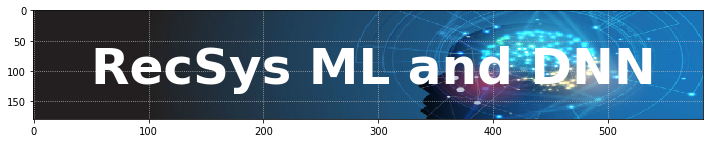

In [1]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
  
# Read Images 
img = mpimg.imread('http://cfile209.uf.daum.net/image/99F55F335DDB5F4112D958') 
  
# Output Images 
plt.figure(figsize=(12,2))
plt.imshow(img, aspect='auto') 
plt.grid(linestyle=':', color='silver')
plt.text(50,120, 'RecSys ML and DNN', color='white', size=50, weight='bold')
plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import polyfit
import matplotlib.style as style 
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')


# to set github url as data path
dataPath = 'https://github.com/stillxyxon/kma_Recsys2020/raw/master/'

# define universally useful UDFs

# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev


def rjitt2(arr):
    stdev = .031*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# custom min max scaler
def mnmx_scl(vec):
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

# custom one-hot encoder
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

## 1. Dataset Loading
- A publicly availble dataset of B2B online retailer
- Data source : https://archive.ics.uci.edu/ml/datasets/online+retail 
- Most of the customers are wholesalers in Europe

In [3]:
# load dataset

# tr01a = tr01.head(270955)
# tr01a.to_csv(dataPath + 'onlineRetail_A.csv', index=False)
print(dataPath + 'onlineRetail_A.csv')

tr01a = pd.read_csv(dataPath + 'onlineRetail_A.csv')

# tr01b = tr01.tail(270954)
# tr01b.to_csv(dataPath + 'onlineRetail_B.csv', index=False)
tr01b = pd.read_csv(dataPath + 'onlineRetail_B.csv')

# to bypass github upload size limitation, read pre-split datasets and merge
tr01 = pd.concat([tr01a, tr01b], axis=0)
print('shape of df : ', tr01.shape)

# include only valid transactions (i.e. exclude returns and cancels )
tr01 = tr01[(tr01.Quantity>0) & tr01.UnitPrice>0]

SCdesc_mast = tr01[['StockCode','Description']].drop_duplicates()

print('num of unique customer IDs :', len(tr01.CustomerID.unique()))
tr01.head()

https://github.com/stillxyxon/kma_Recsys2020/raw/master/onlineRetail_A.csv
shape of df :  (541909, 8)
num of unique customer IDs : 4339


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom


In [4]:
# get list of unique customers

ucusts = list(tr01.CustomerID.unique().astype(int))

import random 

random.sample(ucusts, 100)[:5]

[16571, 17239, 13630, 13341, 16221]

## 2. EDA to design and scope the recsys
- Get frequency for each StockCode (=Item) to understand dataset chracteristics

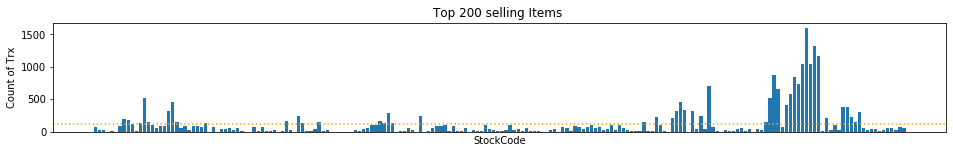

60028


,StockCode,InvoiceNo
3407,85123A,2265
3387,85099B,2112
1310,22423,2017
2670,47566,1706
175,20725,1595


In [5]:
df101 = tr01[['InvoiceNo', 'StockCode']].groupby('StockCode').count().reset_index()

plt.figure(figsize=(16,2))
plt.bar(df101.head(200).StockCode, df101.head(200).InvoiceNo)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.axhline(df101.head(200).InvoiceNo.mean(), color='orange', linestyle=':')
plt.title('Top 200 selling Items ')
plt.ylabel('Count of Trx')
plt.xlabel('StockCode')
plt.show()

nitm = 50
df101 = df101.sort_values(by = 'InvoiceNo', ascending=False).head(nitm)
print(df101.InvoiceNo.sum())
df101.head()

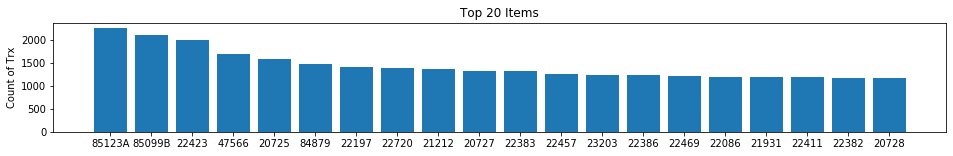

In [6]:
plt.figure(figsize=(16,2))
plt.bar(df101.StockCode[:20], df101.InvoiceNo[:20])
plt.title('Top 20 Items')
plt.ylabel('Count of Trx')
plt.show()

- <font color='blue'>Note that items like POST are not appropriate to be recommended</font>. That's why we need EDA before getting into the main job.

In [7]:
trxdtlcnt = tr01.shape[0]
trxdtlcnt_top20 = tr01[tr01.StockCode.isin(df101.StockCode)].shape[0]
print(trxdtlcnt_top20, trxdtlcnt, '\nTop ', nitm,' items account for ',
      round(trxdtlcnt_top20/trxdtlcnt*100,2), '% of total count of transaction detail')

60028 530106 
Top  50  items account for  11.32 % of total count of transaction detail


- [참고] 전체 건수에서 Top 20 ~ 50 items 가 차지하는 건수 비중이 크지 않지만 단순화하기 위해 여기서는 Top 20~50으로 한정해서
- 실전에서라면 적어도 20~50% coverage 수준의 items을 적용해야 할 것. 
- 추천의 방향성에 맞는 추천 대상 item pool을 선정하기 위한 추가 작업도 필요

In [8]:
ustockcodes = tr01.StockCode.unique()
print('number of unique stockcodes in the dataset : ', len(ustockcodes))

number of unique stockcodes in the dataset :  3922


- 정상매출로 보이는 3922개 stockcode 중 Top 500개를 분석/추천 대상으로 선정하는 경우 51.04% 정도의 trx cnt를 커버할 수 있음

In [9]:
select_stockcodes = list(df101.StockCode)
print(select_stockcodes)

print(len(select_stockcodes))

# Top N 해당하는 StockCode만을 포함하는 trx 건 추출
tr02 = tr01[tr01.StockCode.isin(select_stockcodes)]
print(tr02.shape)
# tr02.head()

print(tr02.CustomerID.unique().shape)

['85123A', '85099B', '22423', '47566', '20725', '84879', '22197', '22720', '21212', '20727', '22383', '22457', '23203', '22386', '22469', '22086', '21931', '22411', '22382', '20728', '22961', '23298', '22960', 'POST', '22666', '23209', '22384', '82482', '22993', '22699', '22727', '23206', '22178', '20724', '20726', '22697', '23084', '21080', '22726', '23199', '22077', '22139', '21034', '22138', '85099C', '22470', '21790', '23301', '82494L', '84946']
50
(60028, 8)
(3763,)


InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132222
Country             0
dtype: int64


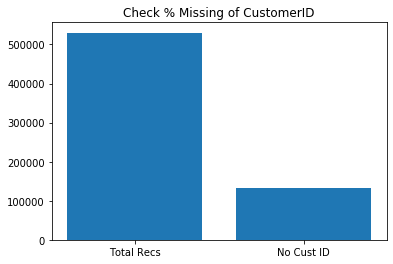

In [10]:
print(tr01.isnull().sum())

recstotal = len(tr01)
recswoCustID = len(tr01[tr01.CustomerID.isnull()])
plt.bar(['Total Recs', 'No Cust ID'],[recstotal,recswoCustID])
plt.title('Check % Missing of CustomerID')
plt.show()

In [11]:
tr01bk = tr01.copy()
tr01 = tr01bk.copy()
tr01 = tr01[~(tr01.CustomerID.isnull())]

In [12]:
# only valid customer transactions
tr01.shape

(397884, 8)

In [13]:
# 숫자로서의 의미가 아닌 CustomerID를 정수형으로 형식 변경

tr01['CustomerID'] = tr01.CustomerID.astype(int)

### Grid 기반의 고객 세분화 Example
- 가장 빈도 높은 2개 상품 거래 건수만을 기준(segmentation dimension)으로 고객 구분 

In [14]:
# create a df of unique customer ID
tr01g = tr01[['CustomerID']].drop_duplicates()

# Top 2 most frequently sold items' codes
print(df101.StockCode.values[:2])

tr01g1 = tr01[tr01.StockCode.isin(['85123A', '85099B'])][['CustomerID','StockCode','InvoiceNo']].drop_duplicates()
tr01g2 = tr01g1.groupby(['CustomerID','StockCode']).count().reset_index()
tr01g3 = tr01g.merge(tr01g2, how='left', on='CustomerID')
tr01g3.fillna(0, inplace=True)

print(tr01g3.head())

tr01g4 = tr01g3.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr01g4.fillna(0, inplace=True)
tr01g4.head(10)

['85123A' '85099B']
   CustomerID StockCode  InvoiceNo
0       17850    85123A       17.0
1       13047    85123A        2.0
2       12583         0        0.0
3       13748         0        0.0
4       15100         0        0.0


StockCode,CustomerID,0,85099B,85123A
0,12346,0.0,0.0,0.0
1,12347,0.0,0.0,0.0
2,12348,0.0,0.0,0.0
3,12349,0.0,0.0,0.0
4,12350,0.0,0.0,0.0
5,12352,0.0,0.0,0.0
6,12353,0.0,0.0,0.0
7,12354,0.0,0.0,0.0
8,12355,0.0,0.0,0.0
9,12356,0.0,0.0,0.0


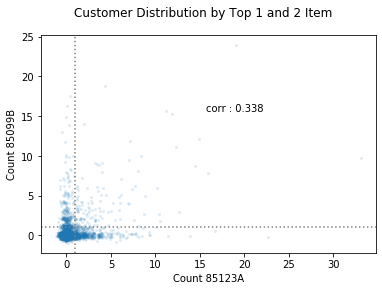

29.253  % of customers bought any of the top two items 


In [15]:
plt.scatter(rjitt(tr01g4['85123A']), rjitt(tr01g4['85099B']), alpha=0.1, s=4)
plt.axhline(1, color='grey', linestyle=':')
plt.axvline(1, color='grey', linestyle=':')
plt.xlabel('Count 85123A')
plt.ylabel('Count 85099B')
plt.suptitle('Customer Distribution by Top 1 and 2 Item')
corr_text = 'corr : ' + str(round(np.corrcoef(tr01g4['85123A'], tr01g4['85099B'])[0,1],3))
plt.text(np.percentile(tr01g4['85123A'],99.9),np.percentile(tr01g4['85099B'],99.9) , corr_text)
plt.show()

pcnt_anyoTop2 = str(round(len(tr01g4[(tr01g4['85123A']>0) | (tr01g4['85099B']>0)]) / len(tr01g4) *100,3))
print(pcnt_anyoTop2, ' % of customers bought any of the top two items ')

In [16]:
tr01g401 = tr01g4.copy() 
tr01g401['85123A'] = np.where(tr01g401['85123A']>1,1,tr01g401['85123A'])
tr01g401['85099B'] = np.where(tr01g401['85099B']>1,1,tr01g401['85099B'])
tr01g401g = tr01g401.groupby(['85123A', '85099B']).count().reset_index()
tr01g401g

StockCode,85123A,85099B,CustomerID,0
0,0.0,0.0,3069,3069
1,0.0,1.0,413,413
2,1.0,0.0,634,634
3,1.0,1.0,222,222


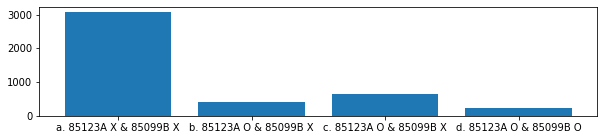

0    3069
1     413
2     634
3     222
Name: CustomerID, dtype: int64

In [17]:
plt.figure(figsize=(10,2))
plt.bar(['a. 85123A X & 85099B X','b. 85123A O & 85099B X','c. 85123A O & 85099B X','d. 85123A O & 85099B O'],
        tr01g401g['CustomerID'])
plt.show()
tr01g401g.CustomerID

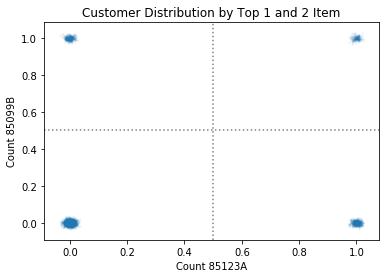

corr :  0.15844995991127842


In [18]:
plt.scatter(rjitt(tr01g401['85123A']), rjitt(tr01g401['85099B']), alpha=0.05, s=2)
plt.axhline(0.5, color='grey', linestyle=':')
plt.axvline(0.5, color='grey', linestyle=':')
plt.xlabel('Count 85123A')
plt.ylabel('Count 85099B')
plt.title('Customer Distribution by Top 1 and 2 Item')
plt.show()
print('corr : ' , np.corrcoef(tr01g401['85123A'], tr01g401['85099B'])[0,1])

[ implications ]
- Top 2 아이템 구매에 상관관계가 존재하지만 매우 높은 것은 아니고, 
- 두 아이템 중 적어도 어느 하나는 구매한 고객이 상당한 비중
- 전체를 커버하지는 못한다하더라도 극단적인 단순함에 비해서는 유용성있는 세분화 (= better than doing nothing?)

# 3. Clustering 
- Clustering Users to make recommendations

- K-Prototype Algorithm for Clustering Mixed attributes - combining k-means and k-modes
- k-modes clustering for categorical data. The mode of a set of data values is the value that appears most often.

In [19]:
# Use only Top 20 items for simplicity

nitm = 20
df101 = df101.sort_values(by = 'InvoiceNo', ascending=False).head(nitm)

select_stockcodes = list(df101.StockCode)
print(select_stockcodes)

print(len(select_stockcodes))

# Top 20 해당하는 StockCode만을 포함하는 trx 건 추출
tr02 = tr01[tr01.StockCode.isin(select_stockcodes)]
tr02.head()

['85123A', '85099B', '22423', '47566', '20725', '84879', '22197', '22720', '21212', '20727', '22383', '22457', '23203', '22386', '22469', '22086', '21931', '22411', '22382', '20728']
20


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 8:34,1.69,13047,United Kingdom
46,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 9:00,2.55,13748,United Kingdom
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 9:02,2.55,17850,United Kingdom
66,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 9:32,2.55,17850,United Kingdom


In [20]:
# 고객별 stockcode별 invoice count 집계 

tr03 = tr02[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()
print(tr03.shape)
tr03.head()

# pivoting to make long format table to be a wide format table 

tr04c = tr03.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr04c.fillna(0, inplace=True)
print(tr04c.shape)
tr04c.head()

(11191, 3)
(3154, 21)


StockCode,CustomerID,20725,20727,20728,21212,21931,22086,22197,22382,22383,...,22411,22423,22457,22469,22720,23203,47566,84879,85099B,85123A
0,12347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,12352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
3,12354,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### K-Means 클러스터링 적용

unique_labels {0, 1, 2, 3}


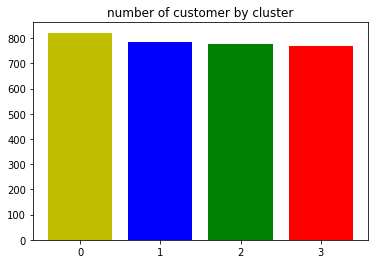

In [21]:
from sklearn.cluster import KMeans  

# df 자체를 할당하는 대신 복제를 생성
df4kmm = tr04c.copy()

# 타입변경은 사실 unnecessary 이미 수치형이라
X = np.array(df4kmm.astype(int))

# create k-means model
kmm1 = KMeans(n_clusters=4, random_state=111)  
# set seed using random_state option
kmm1.fit(X)  

# 군집별 고객수 분포 확인
clst_label, clst_cust_counts = np.unique(kmm1.labels_, return_counts=True)

# 고객집단을 표시할 색상을 임의로 지정
# 번호순의 색상 이름 벡터 생성
unique_labels = set(clst_label) 
print('unique_labels', unique_labels)
colors = ['y', 'b', 'g', 'r', 'grey', 'pink'] 
colors = colors[:len(unique_labels)+1].copy()
colors3 = colors

plt.bar(clst_label.astype(str), clst_cust_counts, color=colors3) 
plt.title('number of customer by cluster')
plt.show()


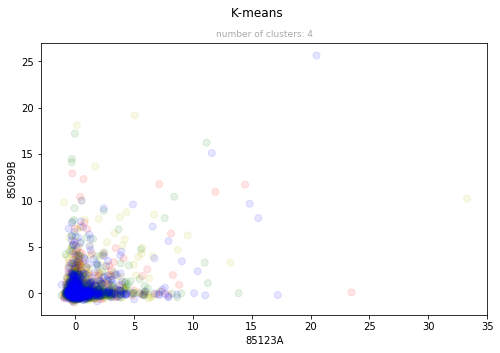

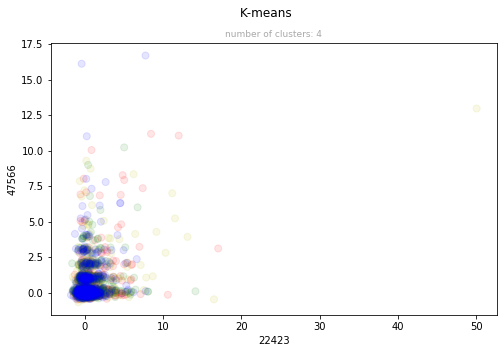

In [22]:

# 각 고객의 소속 집단이 어디인가에 따라 색상 표시
colors4 = [colors3[x] for x in  kmm1.labels_] 
clst_cols = select_stockcodes

for j in [0,2]:
    plt.figure(figsize=(8,5))
    plt.scatter(rjitt(df4kmm[clst_cols[j]]), rjitt(df4kmm[clst_cols[j+1]]),
       color = colors4, s=50, alpha=0.1)

    # subtitle 기능이 직접적으로는 없음. 따라서 우회적 방법 활용
    plt.suptitle("K-means")
    n_clusters_ = 4
    plt.title('number of clusters: %d' %n_clusters_, fontsize=9, color='darkgrey')
    # subtitle 용도로 title을 활용하면서 폰트를 작게

    plt.xlabel(clst_cols[j])
    plt.ylabel(clst_cols[j+1])

    plt.show()
    

### K-Prototype 알고리즘 적용

In [23]:
# Categorical Variable을 포함해서 Clustering 가능

# to create a categorical feature - Max frequency country

idx = tr02[['InvoiceNo','CustomerID','Country']].groupby(['CustomerID','Country'])['InvoiceNo'].transform(max) == tr02['InvoiceNo']
tr04cc = tr02[idx].reset_index()[['CustomerID', 'Country']].drop_duplicates()
tr04cc.head()


,CustomerID,Country
0,18074,United Kingdom
2,16250,United Kingdom
3,17908,United Kingdom
6,17968,United Kingdom
14,16552,United Kingdom


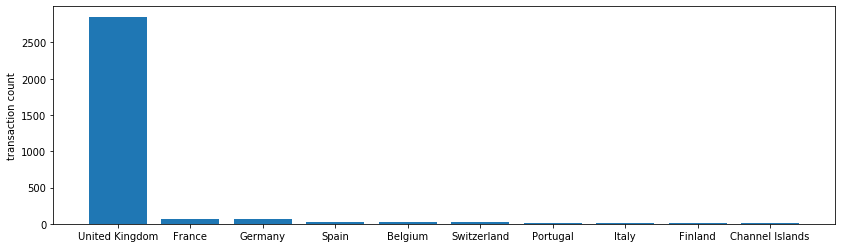

,index,Country
0,United Kingdom,2854
1,France,60
2,Germany,60
3,Spain,23
4,Belgium,22
5,Switzerland,19
6,Portugal,17
7,Italy,11
8,Finland,10
9,Channel Islands,8


In [24]:
# 주로 거래건이 발생되는 country의 분포 (고객별)

dfCountries = tr04cc.Country.value_counts().reset_index().head(10)

plt.figure(figsize=(14,4))
plt.bar(dfCountries['index'], dfCountries.Country)
plt.ylabel('transaction count')
plt.show()

dfCountries

In [25]:
# merge categorical feature 'Country'

tr04c = tr04c.merge(tr04cc, how='left', on='CustomerID')

# fill NAs
tr04c['Country'].fillna('NA', inplace=True)
tr04c.head()

,CustomerID,20725,20727,20728,21212,21931,22086,22197,22382,22383,...,22423,22457,22469,22720,23203,47566,84879,85099B,85123A,Country
0,12347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Iceland
1,12349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Italy
2,12352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,Norway
3,12354,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Spain
4,12355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bahrain


In [26]:
#  https://medium.com/datadriveninvestor/k-prototype-in-clustering-mixed-attributes-e6907db91914

from kmodes.kprototypes import KPrototypes

dfkprt = tr04c.iloc[:,1:22]

kproto = KPrototypes(n_clusters=10, verbose=0)

X = np.array(dfkprt)
clusters = kproto.fit_predict(X, categorical=[20])

# Print cluster centroids of the trained model.
# print(kproto.cluster_centroids_)
# Print training statistics
# print(kproto.cost_)
print(kproto.n_iter_)

dfkprt['clst'] = clusters
dfkprt.head()

22


,20725,20727,20728,21212,21931,22086,22197,22382,22383,22386,...,22457,22469,22720,23203,47566,84879,85099B,85123A,Country,clst
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Iceland,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Italy,6
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,Norway,6
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Spain,6
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bahrain,6


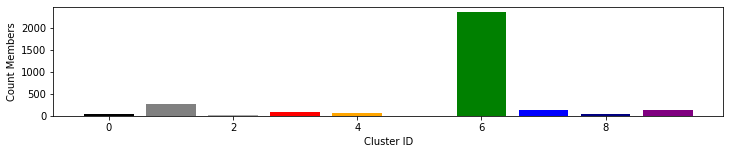

In [27]:
# check distribution of frequency (num of members) in each cluster

# define palette
colist = ['black', 'grey', 'darkgrey', 'red', 'orange', 
          'yellow', 'green', 'blue', 'navy', 'purple']    

# get matching colors with Cluster ID
colors1 = [colist[x] for x in dfkprt['clst'].value_counts().index]

plt.figure(figsize=(12,2))
plt.bar(dfkprt['clst'].value_counts().index,dfkprt['clst'].value_counts(),
       color = colors1)
plt.xlabel('Cluster ID')
plt.ylabel('Count Members')
plt.show()

- 1, 0 번 cluster에 member가 상당히 집중된 결과 생성 (k-means 결과와의 차이는 categorical variable인 country 영향)

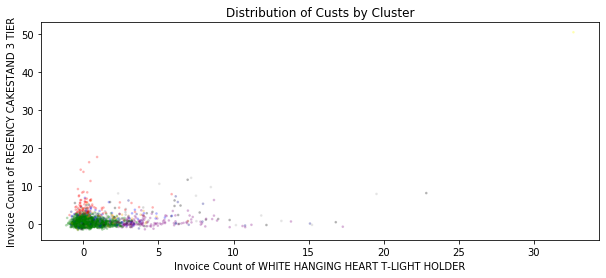

In [28]:
colors1 = [colist[x] for x in clusters]

plt.figure(figsize=(10,4))
plt.scatter(rjitt(dfkprt['85123A']), rjitt(dfkprt['22423']),
            color=colors1, alpha=0.2, s=3)
plt.title('Distribution of Custs by Cluster')
plt.xlabel('Invoice Count of WHITE HANGING HEART T-LIGHT HOLDER')
plt.ylabel('Invoice Count of REGENCY CAKESTAND 3 TIER')    
plt.show()

- 2 top selling items 을 기준으로 scatter plot에서 cluster가 혼재하는 양상을 보인다는 것은?
- 2 top selling items 만으로는 극히 일부분 밖에는 설명할 수 없다는 의미
- Cluster 특징 profiling을 위해 DT, Catboost (Var Importance) 활용 가능

In [29]:
# Profile Clusters : Most popular items in each cluster

dfkprt['CustomerID'] = tr04c.CustomerID

for x in range(3):
    x = x
    mems = dfkprt[dfkprt.clst ==x]['CustomerID']
    tr02tmp = tr02[tr02.CustomerID.isin(mems)][['InvoiceNo','Description']].groupby(['Description']).count().reset_index()
    print('\nCluster', x , '.............\n')
    print(tr02tmp.sort_values('InvoiceNo', ascending=False).head(7))
    print('\n',dfkprt[dfkprt.clst ==x]['Country'].value_counts().head(4))


Cluster 0 .............

                           Description  InvoiceNo
11             LUNCH BAG RED RETROSPOT        274
9              LUNCH BAG  BLACK SKULL.        219
13          LUNCH BAG SPACEBOY DESIGN         203
15              LUNCH BAG SUKI DESIGN         201
10                 LUNCH BAG CARS BLUE        187
24  WHITE HANGING HEART T-LIGHT HOLDER        169
4              JUMBO BAG RED RETROSPOT        115

 United Kingdom    43
France             2
EIRE               1
Name: Country, dtype: int64

Cluster 1 .............

                   Description  InvoiceNo
5      JUMBO BAG RED RETROSPOT        483
11     LUNCH BAG RED RETROSPOT        403
9      LUNCH BAG  BLACK SKULL.        307
12  LUNCH BAG SPACEBOY DESIGN         285
14      LUNCH BAG SUKI DESIGN         267
10         LUNCH BAG CARS BLUE        265
4      JUMBO BAG PINK POLKADOT        243

 United Kingdom    229
Germany             9
France              8
Belgium             4
Name: Country, dtype: int64



[Recommendations using Cluster Model]
- For a customer, find a cluster she belongs
    - List common items of the cluster
    - Recommend items to the customer those have no recent transaction by the customer

- In the meantime, what are the items actually?

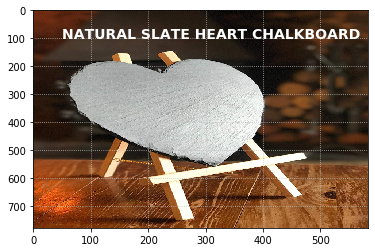

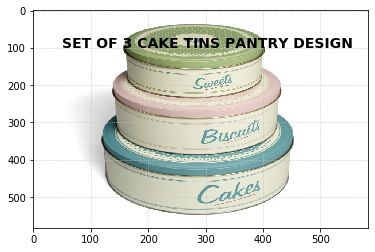

In [30]:
import matplotlib.image as mpimg 
  
# NATURAL SLATE HEART CHALKBOARD
img = mpimg.imread('http://cfile215.uf.daum.net/image/99084B505DDCB8B31138D8') 
  
# Output Images 
plt.imshow(img, aspect='auto') 
plt.grid(linestyle=':', color='silver')
plt.text(50,100, 'NATURAL SLATE HEART CHALKBOARD', color='white', size=14, weight='bold')
plt.show()

# SET OF 3 CAKE TINS PANTRY DESIGN    
img = mpimg.imread('http://cfile230.uf.daum.net/image/99AA6E505DDCB8BA086839') 
  
# Output Images 
plt.imshow(img, aspect='auto') 
plt.grid(linestyle=':', color='silver')
plt.text(50,100, 'SET OF 3 CAKE TINS PANTRY DESIGN', size=14, weight='bold')
plt.show()

- cluster별로 top selling items 구성이 다르다는 것은 cluster를 기준으로 상품 추천시 고객별로 서로 다른 item이 추천될 수 있다는 의미
- customer를 cluster 할 것인가 item을 cluster 할 것인가?

# 4. Collaborative Filtering
- Impementing Item based Fitering

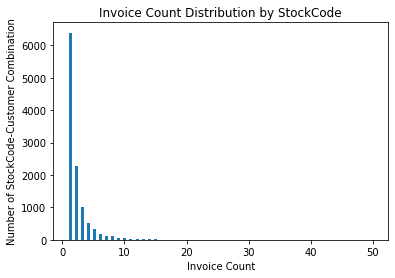

Many items have just a single customer transaction in the data


,StockCode,CustomerID,InvoiceCnt
0,20725,12354,1
1,20725,12361,1
2,20725,12362,2
3,20725,12371,1
4,20725,12378,1


In [31]:
# create an item-user matrix 
# tr02.head()

itmusr_mtrx =  tr02[['InvoiceNo', 'StockCode', 'CustomerID']].groupby(['StockCode','CustomerID']).count().reset_index()
itmusr_mtrx.columns = ['StockCode', 'CustomerID', 'InvoiceCnt']

plt.hist(itmusr_mtrx.InvoiceCnt, bins=100) 
plt.title('Invoice Count Distribution by StockCode')
plt.xlabel('Invoice Count')
plt.ylabel('Number of StockCode-Customer Combination')
plt.show()

print('Many items have just a single customer transaction in the data')

itmusr_mtrx.head()

- 20개 item간의 관계만을 사용해서 CF (for simlicity)
- 실제 구현시에는 item 수 대폭 increase 필요
- Invoice Count 대신 Invoice 여부를 사용할 수도, 다른 metric을 설계할 수도 있음

3154  customers
size of itm-itm matrix :  (400, 3) 

1 th item ..... computed
2 th item ..... computed
3 th item ..... computed
4 th item ..... computed
5 th item ..... computed
6 th item ..... computed
7 th item ..... computed
8 th item ..... computed
9 th item ..... computed
10 th item ..... computed
11 th item ..... computed
12 th item ..... computed
13 th item ..... computed
14 th item ..... computed
15 th item ..... computed
16 th item ..... computed
17 th item ..... computed
18 th item ..... computed
19 th item ..... computed
20 th item ..... computed


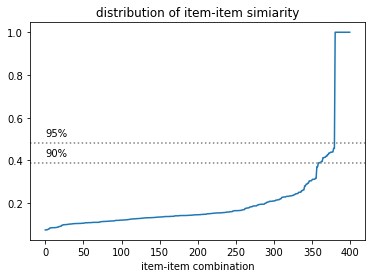

In [32]:
# create item-item matrix

custs = itmusr_mtrx.CustomerID.unique()
print(len(custs), ' customers')

# StockCodeS
scs = itmusr_mtrx.StockCode.unique()
# number of scs
nscs = len(scs)

# create an empty matrix of size width and height
w, h = 3, nscs**2
itmitm_mtrx = np.array([[None for x in range(w)] for y in range(h)])
print('size of itm-itm matrix : ', itmitm_mtrx.shape, '\n')

seqi= 0
for i in scs:
    seqj = 0
    for j in scs:
        # print(i, j, type(i))
        tmpcustsi = itmusr_mtrx[itmusr_mtrx.StockCode ==i]['CustomerID'].unique()
        tmpcustsj = itmusr_mtrx[itmusr_mtrx.StockCode ==j]['CustomerID'].unique()
        # print(len(tmpcustsi), len(tmpcustsj))

        # print([seqi, seqj, len(set(tmpcustsi) & set(tmpcustsi)) , list(set().union(tmpcustsi, tmpcustsj))])
        
        # 비교대상이 되는 두 고객집단 (item i를 구매한 고객리스트와 j를 구매한 고객리스트) 간의 
        # 교집합 고객수를 합집합 고객수로 나눈 값으로 simiarity 측정
        itmitm_mtrx[(seqi*nscs) + seqj] = [i, j, len(set(tmpcustsi) & set(tmpcustsj)) / len(set().union(tmpcustsi, tmpcustsj))]
        
        if seqj<nscs:
            seqj = seqj + 1
            
    if seqi<nscs:        
        seqi = seqi + 1    
    print(seqi, 'th item ..... computed') 
        

itmitm_mtrx = pd.DataFrame(itmitm_mtrx)
itmitm_mtrx.columns =['StockCode','SCj','simScr']

plt.plot(np.sort(itmitm_mtrx.simScr))
plt.title('distribution of item-item simiarity')

# 추천시 사용할 cutoff 를 확인하기 위해
plt.axhline(np.percentile(itmitm_mtrx.simScr,95), linestyle=':', color='grey')
plt.text(0,np.percentile(itmitm_mtrx.simScr,95)+0.03, '95%')
plt.axhline(np.percentile(itmitm_mtrx.simScr,90), linestyle=':', color='grey')
plt.text(0,np.percentile(itmitm_mtrx.simScr,90)+0.03, '90%')
plt.xlabel('item-item combination')
plt.show()

- 유사도 계산에 교집합과 합집합간의 비율 사용시 100/1000 == 200/2000 이라는 문제점 존재 (i.e. 비교대상 item들의 popularity 무시)

- 합집합은 무시하고 교집합의 크기를 추가적인 가중치 factor로 사용하는 등 다양한 아이디어 활용 가능

In [33]:
print(itmitm_mtrx.shape)
# 20X20 matrix 이므로 400

itmitm_mtrx.head()

# itmitm_mtrx[itmitm_mtrx.StockCode.isin(['20725','20727'])]

(400, 3)


,StockCode,SCj,simScr
0,20725,20725,1
1,20725,20727,0.434783
2,20725,20728,0.438122
3,20725,21212,0.205579
4,20725,21931,0.233951


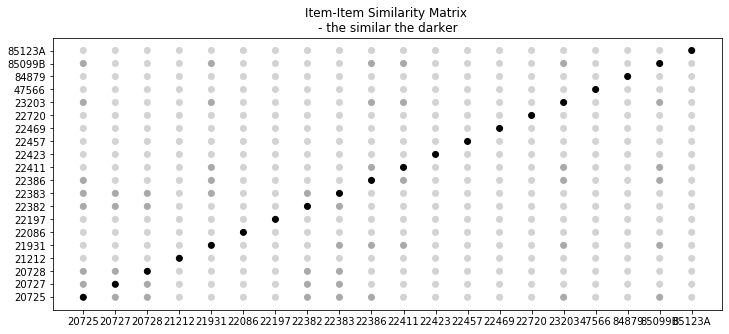

In [34]:
plt.figure(figsize=(12,5)) 
monocolpal = ['black', 'dimgray', 'darkgray', 'lightgrey', 'white']
simScr5 = 4-np.array(itmitm_mtrx.simScr * 4).astype(int) -1 
simScr5 = np.where(simScr5<0,0,simScr5)

colors1 = [monocolpal[x] for x in simScr5]
plt.scatter(itmitm_mtrx.StockCode, itmitm_mtrx.SCj, color=colors1)
plt.title('Item-Item Similarity Matrix \n- the similar the darker')
plt.show()

- [ 참고 ] 기준이되는 item을 정한 후 계산하기 때문에 matrix가 대칭이 아님
- Pattern 특성 : Frequency가 높은 item은 다른 item들과의 similarity가 전반적으로 높음 (--> 분산을 위해 의도적 조정 여지 존재)

### Making recommendations (inference) in item-based filtering

- StockCode와 Description(i.e. Item Name) 간에 M:N 관계일 경우 StockCode 기준의 추천 로직에서 추천시 문제 발생

In [35]:
# create a cleansed item name master table

# using SCdesc_mast
multnmScList = SCdesc_mast.StockCode.value_counts()
multnmScList = multnmScList[multnmScList>1]
print('\nCount of different descriptions of the same StockCodes')
print(multnmScList[:10])

print('\nStockCodes with Desription Matching Issues')
SCdesc_mast[SCdesc_mast.StockCode.isin(multnmScList[:5].index)].sort_values('StockCode')


Count of different descriptions of the same StockCodes
23196    4
23236    4
23244    3
23203    3
23209    3
22776    3
23535    3
23131    3
23370    3
23231    3
Name: StockCode, dtype: int64

StockCodes with Desription Matching Issues


,StockCode,Description
238991,23196,RETO LEAVES MAGNETIC SHOPPING LIST
252851,23196,VINTAGE LEAF MAGNETIC NOTEPAD
246802,23196,LEAVES MAGNETIC SHOPPING LIST
237422,23196,RETRO LEAVES MAGNETIC NOTEPAD
21700,23203,JUMBO BAG VINTAGE DOILY
20022,23203,JUMBO BAG VINTAGE DOILEY
178609,23203,JUMBO BAG DOILEY PATTERNS
21722,23209,LUNCH BAG VINTAGE DOILY
20024,23209,LUNCH BAG VINTAGE DOILEY
179020,23209,LUNCH BAG DOILEY PATTERN


In [36]:
# get inoive counts by StockCode-Description combination

dfscList = tr01[['StockCode','Description', 'InvoiceNo']].groupby(['StockCode','Description']).count().reset_index().sort_values(['StockCode','InvoiceNo'], ascending=False)
dfscmulList = dfscList[dfscList.StockCode.isin(multnmScList.index)]
dfscmulList.head()

,StockCode,Description,InvoiceNo
3591,90014C,SILVER/BLACK ORBIT NECKLACE,2
3590,90014C,SILVER AND BLACK ORBIT NECKLACE,1
3588,90014B,GOLD M PEARL ORBIT NECKLACE,6
3589,90014B,GOLD M.O.P. ORBIT NECKLACE,2
3587,90014A,SILVER/MOP ORBIT NECKLACE,7


In [37]:
# get the most frequent descriptions for eacg stockcode

dfmxcntSCdesc = pd.DataFrame(dfscmulList.groupby(['StockCode'], sort=False).max()).reset_index()
dfmxcntSCdesc.head(20).sort_values('StockCode')

,StockCode,Description,InvoiceNo
19,81950V,FLOWER PURPLE CLOCK WITH SUCKER,4
18,82001S,VINYL RECORD FRAME SILVER,87
17,82486,WOOD S/3 CABINET ANT WHITE FINISH,378
16,82600,NO SINGING METAL SIGN,388
15,84228,HEN HOUSE WITH CHICK STANDING,16
14,84247E,PACK/12 XMAS FUN CARD,15
13,84828,JUNGLE POPSICLES ICE LOLLY MOULDS,100
12,84906,PINK BUTTERFLY CUSHION COVER,6
11,84946,ANTIQUE SILVER TEA GLASS ETCHED,541
10,84997A,GREEN 3 PIECE POLKADOT CUTLERY SET,166


In [38]:
SCdesc_masta = SCdesc_mast[['StockCode']].drop_duplicates()
SCdesc_masta = SCdesc_masta.merge(dfmxcntSCdesc[['StockCode', 'Description']], on='StockCode', how='left')
SCdesc_masta[~SCdesc_masta.Description.isna()].sort_values('StockCode').head(500).tail(20)

,StockCode,Description
2470,81950V,FLOWER PURPLE CLOCK WITH SUCKER
1680,82001S,VINYL RECORD FRAME SILVER
53,82486,WOOD S/3 CABINET ANT WHITE FINISH
714,82600,NO SINGING METAL SIGN
2034,84228,HEN HOUSE WITH CHICK STANDING
2274,84247E,PACK/12 XMAS FUN CARD
1279,84828,JUNGLE POPSICLES ICE LOLLY MOULDS
343,84906,PINK BUTTERFLY CUSHION COVER
963,84946,ANTIQUE SILVER TEA GLASS ETCHED
1127,84997A,GREEN 3 PIECE POLKADOT CUTLERY SET


In [39]:
dfscSnglList= SCdesc_mast[~SCdesc_mast.StockCode.isin(dfmxcntSCdesc.StockCode)]
print(dfscSnglList.sort_values('StockCode').head())
SCdesc_masta = SCdesc_masta.merge(dfscSnglList, on='StockCode', how='left')
print(SCdesc_masta.head())

SCdesc_masta['Description'] = SCdesc_masta.Description_x
SCdesc_masta['Description'] = np.where(SCdesc_masta.Description.isna(),SCdesc_masta.Description_y, SCdesc_masta.Description)
SCdesc_mast = SCdesc_masta[['StockCode','Description']]
SCdesc_masta.head()

       StockCode                  Description
31         10002  INFLATABLE POLITICAL GLOBE 
103332     10080     GROOVY CACTUS INFLATABLE
5452       10120                 DOGGY RUBBER
5451      10123C        HEARTS WRAPPING TAPE 
12492     10124A  SPOTS ON RED BOOKCOVER TAPE
  StockCode                       Description_x  \
0    85123A  WHITE HANGING HEART T-LIGHT HOLDER   
1     71053        WHITE MOROCCAN METAL LANTERN   
2    84406B                                 NaN   
3    84029G                                 NaN   
4    84029E                                 NaN   

                         Description_y  
0                                  NaN  
1                                  NaN  
2       CREAM CUPID HEARTS COAT HANGER  
3  KNITTED UNION FLAG HOT WATER BOTTLE  
4       RED WOOLLY HOTTIE WHITE HEART.  


,StockCode,Description_x,Description_y,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE MOROCCAN METAL LANTERN,NaN,WHITE MOROCCAN METAL LANTERN
2,84406B,NaN,CREAM CUPID HEARTS COAT HANGER,CREAM CUPID HEARTS COAT HANGER
3,84029G,NaN,KNITTED UNION FLAG HOT WATER BOTTLE,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,NaN,RED WOOLLY HOTTIE WHITE HEART.,RED WOOLLY HOTTIE WHITE HEART.


Customer  0  : 
-------------
 Bought : 
 ['PACK OF 72 RETROSPOT CAKE CASES'] 

 Recommends : 



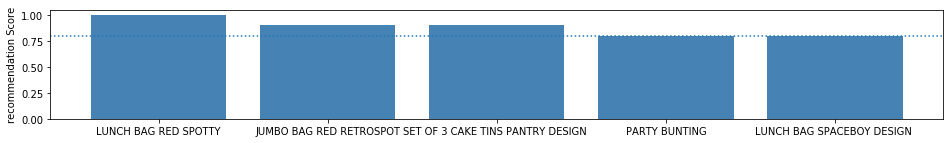

Customer  1  : 
-------------
 Bought : 
 ['WHITE HANGING HEART T-LIGHT HOLDER' "PAPER CHAIN KIT 50'S CHRISTMAS "
 'PACK OF 72 RETROSPOT CAKE CASES' 'PARTY BUNTING'] 

 Recommends : 



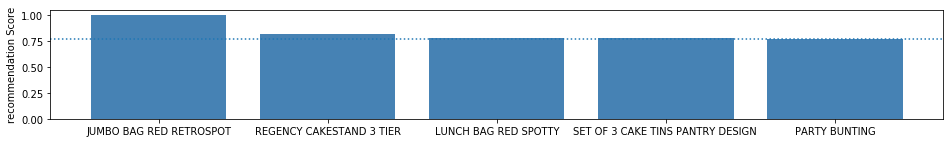

Customer  2  : 
-------------
 Bought : 
 ['WHITE HANGING HEART T-LIGHT HOLDER' 'JUMBO BAG PINK POLKADOT'
 'LUNCH BAG RED SPOTTY' 'JUMBO STORAGE BAG SUKI'
 'JUMBO SHOPPER VINTAGE RED PAISLEY' 'JUMBO BAG RED RETROSPOT'
 'LUNCH BAG CARS BLUE' 'REGENCY CAKESTAND 3 TIER'
 'SET OF 3 CAKE TINS PANTRY DESIGN ' 'JUMBO BAG VINTAGE DOILY '] 

 Recommends : 



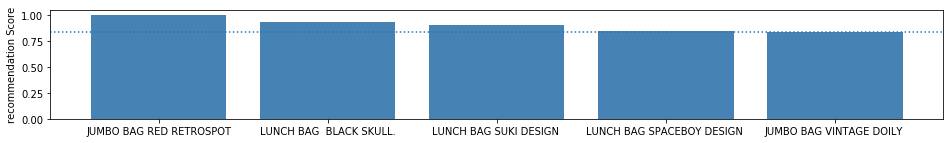

Customer  3  : 
-------------
 Bought : 
 ['WHITE HANGING HEART T-LIGHT HOLDER' "PAPER CHAIN KIT 50'S CHRISTMAS "
 'JUMBO BAG PINK POLKADOT' 'PACK OF 72 RETROSPOT CAKE CASES'
 'JUMBO STORAGE BAG SUKI' 'NATURAL SLATE HEART CHALKBOARD '
 'HEART OF WICKER SMALL' 'JUMBO BAG RED RETROSPOT' 'LUNCH BAG CARS BLUE'
 'LUNCH BAG  BLACK SKULL.'] 

 Recommends : 



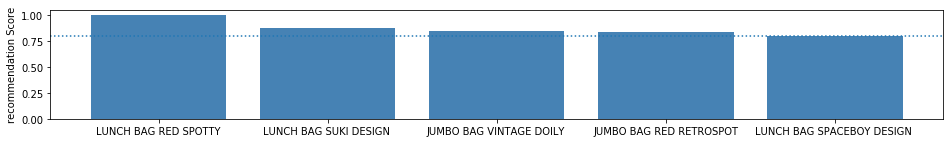

In [40]:
# to pick samples 
import random
from random import sample 

# get random sample of customers for test recommendations
smp_custs = np.array(random.sample(list(custs), 10)).astype(int)


# select items to recommend
for i in range(4):
    tmptrx = tr02[tr02.CustomerID == smp_custs[i]][['StockCode', 'CustomerID']].drop_duplicates()
    
    # Note: (itmitm_mtrx.simScr<1) prevents to recommend items already bought
    # (itmitm_mtrx.simScr>0.15) 값을 조절해서 0.2로 변경시 추천이 원하는 수 만큼 생성되지 않음 
    # 스코어 분포를 고려한 조절 필요
    
    tmpsimmat01 = itmitm_mtrx[(itmitm_mtrx.simScr>0.15) & (itmitm_mtrx.simScr<1)][itmitm_mtrx.StockCode.isin(tmptrx.StockCode.unique())].drop_duplicates()
    tmpsimmat02 = tmpsimmat01[['SCj','simScr']].groupby('SCj').sum().reset_index()
    # rescale -- thus simScr indicates relative score
    tmpsimmat02['simScr'] = tmpsimmat02.simScr / tmpsimmat02.simScr.max()
    # print(tmpsimmat02.sort_values('simScr', ascending=False).head(5))
    dfrecomm = tmpsimmat02.sort_values('simScr', ascending=False).head(5)
    dfrecomm.columns = ['StockCode','simScr']
    dfrecomm = dfrecomm.merge(SCdesc_mast, how='left', on='StockCode')
    print('Customer ',i, ' : \n-------------\n', 
          'Bought : \n', np.array(SCdesc_mast[SCdesc_mast.StockCode.isin(tmptrx.StockCode.unique())].Description), '\n\n', 
          'Recommends : \n' )
    plt.figure(figsize=(16,2)) 
    plt.bar(dfrecomm.Description, dfrecomm.simScr, color='steelblue')
    plt.axhline(dfrecomm.simScr.min(), linestyle=':')
    plt.ylabel('recommendation Score')
    plt.show()
    

- Similarity metric 유사도 산출식으로 cosine similarity (https://en.wikipedia.org/wiki/Cosine_similarity) 많이 사용. 

In [41]:
# Cosine 유사도 사용 연습

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

x = [0.5,0.2,0.7]

# y = [0.5,0.4,0.7]
# y = [0.5,0.7,0.4]
y = [0.2,0.9,0.1]

# x = [2,1,3]
# y = [4,2,6]

print(cosine_similarity(x,x))
print(cosine_similarity(x,1-np.array(x)))
print(cosine_similarity(x,y))


1.0
0.7091389668511001
0.4273380041923163


# 5. DNN-based RecSys

In [42]:
# Use only Top 20 items

nitm = 20
df101 = df101.sort_values(by = 'InvoiceNo', ascending=False).head(nitm)

select_stockcodes = list(df101.StockCode)
print(select_stockcodes)

print(len(select_stockcodes))

# Top 20 해당하는 StockCode만을 포함하는 trx 건 추출
tr02 = tr01[tr01.StockCode.isin(select_stockcodes)]

['85123A', '85099B', '22423', '47566', '20725', '84879', '22197', '22720', '21212', '20727', '22383', '22457', '23203', '22386', '22469', '22086', '21931', '22411', '22382', '20728']
20


## 5.1. 기간 구분 (partitioning)
- 추천시스템을 과거의 사용자 행동 시그널을 바탕으로 미래의 이용 패턴을 예측하는 방식으로 구성
- 목적에 따른 기간의 구성에 따라 초단기, 단기 등 다양한 선택 가능

In [43]:
# Months for X (input feature)
tr021 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-03', '2011-04', '2011-05'])]

# Months for Y (target variable)
tr022 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-06'])]

# tr021.head()
tr022.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
209033,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 7:38,12.75,15643,United Kingdom
209036,555157,47566,PARTY BUNTING,8,2011-06-01 7:38,4.95,15643,United Kingdom
209070,555158,21931,JUMBO STORAGE BAG SUKI,10,2011-06-01 8:38,2.08,14842,United Kingdom
209089,555158,22423,REGENCY CAKESTAND 3 TIER,2,2011-06-01 8:38,12.75,14842,United Kingdom
209113,555158,84879,ASSORTED COLOUR BIRD ORNAMENT,8,2011-06-01 8:38,1.69,14842,United Kingdom


## 5.2. Input and Target Feature 생성 (Aggregation)

In [44]:
tr03 = tr021[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()
print(tr03.shape)
tr03.head()

(4001, 3)


,CustomerID,StockCode,InvoiceNo
0,12347,22423,1
1,12354,20725,1
2,12355,22423,1
3,12356,21212,1
4,12356,22423,1


In [45]:
# pivoting to make long format table to wide format table 

tr04 = tr03.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr04.fillna(0, inplace=True)

# add prefix sc (=StockCode)
sc_list = np.char.array(['sc']) + np.array(tr04.columns[1:(nitm+1)])
tr04.columns = np.concatenate([np.array(['CustomerID']), sc_list])
print(tr04.shape)
tr04.head()


(1392, 21)


,CustomerID,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,...,sc22411,sc22423,sc22457,sc22469,sc22720,sc23203,sc47566,sc84879,sc85099B,sc85123A
0,12347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12354,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12356,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


- 20개 top selling items 만을 input feature로 사용했으나 더 많은 feature들을 사용하는 것 가능. -- 통상 다수의 item을 feature로 사용. 단, resource 부담 감수
- aggregation of item trx count 이외의 성격의 input feature 추가 가능 (e.g. 고객의 규모, 고객의 geo-location, nationality, demographics(B2C 경우) 등)

In [46]:
# target variable 생성해 결합

tr05 = tr022[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()
print(tr05.shape)

tr06 = tr05.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr06.fillna(0, inplace=True)

# add prefix sct (= Target SC )
sc_list = np.char.array(['sct']) + np.array(tr06.columns[1:(nitm+1)])
tr06.columns = np.concatenate([np.array(['CustomerID']), sc_list])
print(tr06.shape)

tr07 = tr04.merge(tr06, on='CustomerID', how='left')
tr07.fillna(0, inplace=True)
tr07['seqM'] = 1
print('shape of training set : ', tr07.shape)
tr07.head()


(1686, 3)
(627, 21)
shape of training set :  (1392, 42)


,CustomerID,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,...,sct22423,sct22457,sct22469,sct22720,sct23203,sct47566,sct84879,sct85099B,sct85123A,seqM
0,12347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,12354,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,12355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,12356,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,12362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


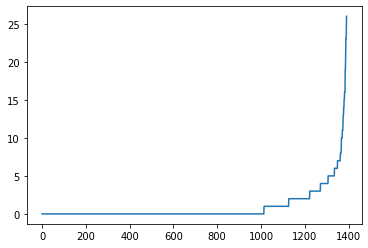

In [47]:
plt.plot(np.sort(tr07.loc[:,tr07.columns[21:41]].sum(axis=1)))
plt.show()

# 다수의 고객이 Top 20개 item 중 아무 것도 target 기간 중 거래하지 않음

- 1개월 기간을 이동시킨 train dataset을 추가로 생성 -- 계절적 차이 영향 완화 및  sample size 증대 효과
- 실제 상황에서는 더 많은 시점을 동시 고려하는 것이 바람직할 수 있음

In [48]:
# Months for train X
tr023 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-04', '2011-05', '2011-06'])]
# Months for train Y
tr024 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-07'])]

tr11 = tr023[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()
print(tr11.shape)

tr12 = tr11.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr12.fillna(0, inplace=True)

# add prefix sc
sc_list = np.char.array(['sc']) + np.array(tr12.columns[1:(nitm+1)])
tr12.columns = np.concatenate([np.array(['CustomerID']), sc_list])

tr13 = tr024[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()

tr14 = tr13.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr14.fillna(0, inplace=True)

# add prefix sc
sc_list = np.char.array(['sct']) + np.array(tr14.columns[1:(nitm+1)])
tr14.columns = np.concatenate([np.array(['CustomerID']), sc_list])
print(tr14.shape)

tr15 = tr12.merge(tr14, on='CustomerID', how='left')
tr15.fillna(0, inplace=True)
tr15['seqM'] = 2
tr15.head()



(4025, 3)
(621, 21)


,CustomerID,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,...,sct22423,sct22457,sct22469,sct22720,sct23203,sct47566,sct84879,sct85099B,sct85123A,seqM
0,12347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,12354,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,12355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,12356,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,12359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [49]:
# 서로 다른 두 개 시점을 기준으로 생성한 set을 통합해 train set 완성

tr071 = pd.concat([tr07, tr15], axis=0)
print(tr071.shape)
tr071.head()

(2766, 42)


,CustomerID,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,...,sct22423,sct22457,sct22469,sct22720,sct23203,sct47566,sct84879,sct85099B,sct85123A,seqM
0,12347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,12354,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,12355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,12356,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,12362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


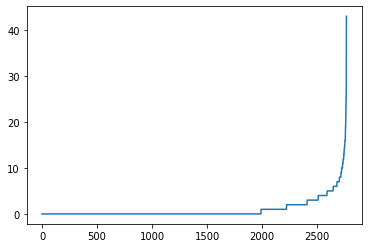

In [50]:
plt.plot(np.sort(tr071.loc[:,tr071.columns[21:41]].sum(axis=1)))
plt.show()

# 다수의 고객이 Top 20개 item 중 아무 것도 target 기간 중 거래하지 않음
# . . . . . DNN 모델의 학습에 유용한 training sample?

In [51]:
# excluding customers of no transaction in top 20 items ?

'''
tr071['targetSum'] = tr071.loc[:,tr071.columns[21:41]].sum(axis=1)
tr071 = tr071[tr071.targetSum>0].drop('targetSum', axis=1)
tr071.shape
'''

# False Positve Error로 인해 Accuracy는 감소하지만, Recall은 증가
#  -- Recoomendation이 여러 item으로 좀 더 분산되는 효과 발생

"\ntr071['targetSum'] = tr071.loc[:,tr071.columns[21:41]].sum(axis=1)\ntr071 = tr071[tr071.targetSum>0].drop('targetSum', axis=1)\ntr071.shape\n"

In [52]:
# X set 과 Y set 분리 

X_train = tr071.iloc[:,1:(nitm+1)]
y_train = tr071.iloc[:,(nitm+1):((2*nitm)+1)]

X_train.head()

,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,sc22386,sc22411,sc22423,sc22457,sc22469,sc22720,sc23203,sc47566,sc84879,sc85099B,sc85123A
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [53]:
y_train.head()

,sct20725,sct20727,sct20728,sct21212,sct21931,sct22086,sct22197,sct22382,sct22383,sct22386,sct22411,sct22423,sct22457,sct22469,sct22720,sct23203,sct47566,sct84879,sct85099B,sct85123A
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
tr071.shape

(2766, 42)

In [55]:
# EDA on the relationship between variables 

# to check correlations between Xi and Yi - check propensity of repeat purchase

tmparr = np.array([]).astype(float)

for x in range(nitm):
    tmparr = np.append(tmparr, np.corrcoef(X_train.iloc[:,x], y_train.iloc[:,x])[0,1])
print(tmparr)    
print(tmparr.mean())

[ 0.48985069  0.47079295  0.52180789  0.229868    0.43270132 -0.00502763
  0.54768044  0.37308625  0.44522265  0.44711176  0.43656554  0.42548274
  0.26204754  0.15317444  0.30517064  0.35891833  0.42106563  0.39657184
  0.4729966   0.40160797]
0.3793347782858557


- 동일 상품을 반복해서 (=서로 다른 기간에도) 구매하는 패턴이 상당함을 확인
- 단, 상품별로 차이 존재 (= 구매주기의 차이일 가능성 존재)

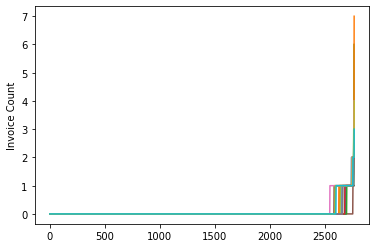

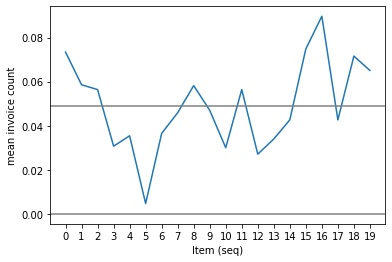

In [56]:
# check distibution of the target variables 

means = np.array([]).astype(int)
means
for x in range(0,nitm):
    plt.plot(np.sort(y_train.iloc[:,x]))
    means = np.append(means, y_train.iloc[:,x].mean())
plt.ylabel('Invoice Count')    
plt.show()    

plt.plot(np.array(range(0,nitm)).astype(str), means)
plt.axhline(means.mean(), color='grey')
plt.axhline(0, color='grey')
plt.xlabel('Item (seq)')
plt.ylabel('mean invoice count')
plt.show()

- Target (예측대상 품목별 이용 결과) 변수의 형식을 구매여부, 구매금액, 구매빈도 등 다양한 방식으로 정의할 수 있음
- 추천서비스의 궁극적 목표에 따라 다른 설계 필요

In [57]:
# to binarize  [ Optonal ]
# 10개 item의 구매여부를 classification 문제 형식으로 정의

# for x in range(nitm):
#     y_train.iloc[:,x] = np.where(y_train.iloc[:,x]>0,1,0) # Target
#     X_train.iloc[:,x] = np.where(X_train.iloc[:,x]>0,1,0) # inputs

In [58]:
# to binarize target :: # 10개 item의 구매여부를 classification 문제 형식으로 정의
# to quantile-based normalized inputs (c.f. YouTube 2016) ... [ Optional ]

from scipy.stats import percentileofscore

# X1_tmp = X_train.iloc[:,1].copy()
# arr_sorted =  sorted(np.array(X_train.iloc[:,1].copy()))
# s = X_train.iloc[:,1]
# X1_tmp_qn = mnmx_scl(s.apply(lambda x: percentileofscore(arr_sorted, x)/100))  # inputs

# plt.scatter(X1_tmp, X1_tmp_qn)
# plt.xlabel('original')
# plt.ylabel('quantile normalized')
# plt.show()


for x in range(nitm):
    y_train.iloc[:,x] = np.where(y_train.iloc[:,x]>0,1,0) # Target
    
    arr_sorted =  sorted(np.array(X_train.iloc[:,x].copy()))
    s = X_train.iloc[:,x]
    X_train.iloc[:,x] = mnmx_scl(s.apply(lambda x: percentileofscore(arr_sorted, x)/100))  # inputs
    
X_train.tail()    

,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,sc22386,sc22411,sc22423,sc22457,sc22469,sc22720,sc23203,sc47566,sc84879,sc85099B,sc85123A
1369,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.731416,0.000000,0.000000,0.000000
1370,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.881256,0.000000,0.000000,0.0,0.0,0.0,0.868505,0.000000,0.000000,0.000000,0.000000
1371,0.000000,0.000000,0.000000,0.827396,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.755009,0.0,0.0,0.0,0.000000,0.923668,0.958106,0.000000,0.000000
1372,0.000000,0.000000,0.000000,0.827396,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1373,0.998149,0.988436,0.996492,0.975737,0.994373,0.0,0.881162,0.99582,0.995255,0.994112,0.894545,0.000000,0.0,0.0,0.0,0.980436,0.000000,0.000000,0.994181,0.931961


- 구매여부 대신 구매건수를 타겟으로 설정하는 것도 대안
- c.f. YouTube는 시청시간이 메인타겟
- 여기서는 input feature를 건수 형식으로 정의 (단, 분포 변환 실시)
- Quantile Nomaization은 각 feature의 분포에서 각 obs가 가지는 quantile 값(0~1) 으로 변환해 코딩

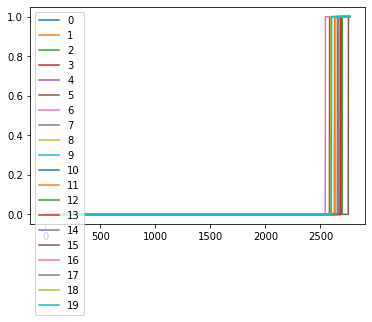

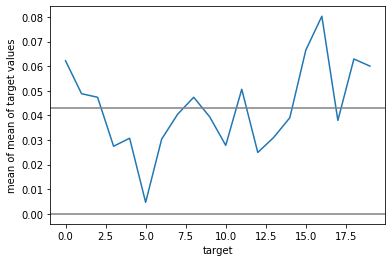

In [59]:
means = np.array([]).astype(int)
means
for x in range(nitm):
    plt.plot(np.sort(y_train.iloc[:,x]))
    means = np.append(means, y_train.iloc[:,x].mean())
plt.legend(list(range(nitm)), loc='upper left')
plt.show()    

plt.plot(range(0,nitm), means)
plt.axhline(means.mean(), color='grey')
plt.axhline(0, color='grey')
plt.xlabel('target')
plt.ylabel('mean of mean of target values')
plt.show()

In [60]:
tmparr = np.array([]).astype(float)

for x in range(nitm):
    tmparr = np.append(tmparr, np.corrcoef(X_train.iloc[:,x], y_train.iloc[:,x])[0,1])
print(tmparr) 
print('\nmean of corr = ' , tmparr.mean(), ' # 구매건수간의 상관관계에 비해 변환 후 상관관계 약간 감소')

y_train.head()

[ 0.37783154  0.33448917  0.29885265  0.16910448  0.34255717 -0.00524157
  0.40794923  0.31019882  0.33418791  0.3580654   0.35266814  0.25119211
  0.17755572  0.16402706  0.24071304  0.33754101  0.33180825  0.32356117
  0.40274567  0.33220913]

mean of corr =  0.2921008045625336  # 구매건수간의 상관관계에 비해 변환 후 상관관계 약간 감소


,sct20725,sct20727,sct20728,sct21212,sct21931,sct22086,sct22197,sct22382,sct22383,sct22386,sct22411,sct22423,sct22457,sct22469,sct22720,sct23203,sct47566,sct84879,sct85099B,sct85123A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
y_train.columns[:nitm]

Index(['sct20725', 'sct20727', 'sct20728', 'sct21212', 'sct21931', 'sct22086',
       'sct22197', 'sct22382', 'sct22383', 'sct22386', 'sct22411', 'sct22423',
       'sct22457', 'sct22469', 'sct22720', 'sct23203', 'sct47566', 'sct84879',
       'sct85099B', 'sct85123A'],
      dtype='object')

In [62]:
# check distribution stats

print('mean of X_train : \n', X_train.mean(axis=0), '\n\nStdev : \n', X_train.std(axis=0))
print('\nmean of Y_train : \n',y_train.mean(axis=0), '\n\nStdev : \n', y_train.std(axis=0),)

# Y 기간은 1개월이기 때문에 correlation 상대적으로 낮음 - fluctuaton
# Classification 형태로 구성하려고 하지만 class imbalance 상당히 존재 = rare event prediction 
# Y 기간이 더 짧아진다면(예: 1일) 그 만큼 imbalance 는 더 커질 것

print('\n평균 target event 비율 : ', y_train.mean(axis=0).mean())

mean of X_train : 
 sc20725     0.147177
sc20727     0.111789
sc20728     0.118304
sc21212     0.151106
sc21931     0.084740
sc22086     0.005755
sc22197     0.097943
sc22382     0.110932
sc22383     0.125593
sc22386     0.095518
sc22411     0.085950
sc22423     0.208643
sc22457     0.121145
sc22469     0.076846
sc22720     0.088061
sc23203     0.113534
sc47566     0.212475
sc84879     0.161202
sc85099B    0.153139
sc85123A    0.209834
dtype: float64 

Stdev : 
 sc20725     0.323689
sc20727     0.295242
sc20728     0.301150
sc21212     0.325699
sc21931     0.265634
sc22086     0.075468
sc22197     0.281186
sc22382     0.294358
sc22383     0.307623
sc22386     0.278411
sc22411     0.267123
sc22423     0.351223
sc22457     0.303462
sc22469     0.255311
sc22720     0.269552
sc23203     0.296792
sc47566     0.353155
sc84879     0.332088
sc85099B    0.327290
sc85123A    0.352416
dtype: float64

mean of Y_train : 
 sct20725     0.062184
sct20727     0.048807
sct20728     0.047361
sct21212   

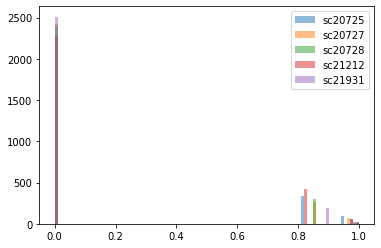

,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,sc22386,sc22411,sc22423,sc22457,sc22469,sc22720,sc23203,sc47566,sc84879,sc85099B,sc85123A
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.755009,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.810552,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.755009,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.827396,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.755009,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.865916,0.839291,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.731416,0.0,0.0,0.0


In [63]:
for x in range(5):
    plt.hist(X_train.iloc[:,x], bins=100, alpha=0.5)
plt.legend(X_train.columns[:5])
plt.show()

X_train.head()

- YouTube(2016) 사용한 방식의 mimic으로 add super and sub linear derivatives of input features

In [64]:
# add super and sub linear derivatives of input features

# squared as super-linear
X_train_supl = X_train.apply(lambda x: x**2)
X_train_supl.columns = np.char.array(['sup']) + np.array(X_train_supl.columns)

# sqrt as sub-linear
X_train_subl = X_train.apply(lambda x: np.sqrt(x))
X_train_subl.columns = np.char.array(['sub']) + np.array(X_train_subl.columns)

X_train = pd.concat([X_train, X_train_supl, X_train_subl], axis=1)
X_train.shape

(2766, 60)

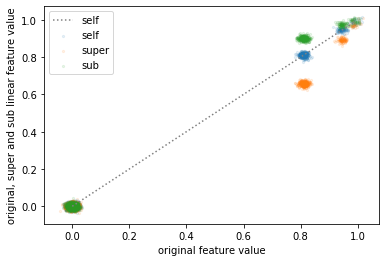

In [65]:
# compare distributions of orginal, super and sub features

plt.scatter(rjitt(X_train.sc20725), rjitt(X_train.sc20725), alpha=0.1, s=5)
plt.scatter(rjitt(X_train.sc20725), rjitt(X_train.supsc20725), alpha=0.1, s=5)
plt.scatter(rjitt(X_train.sc20725), rjitt(X_train.subsc20725), alpha=0.1, s=5)
plt.plot(np.array(range(100))/100, np.array(range(100))/100, color='grey', linestyle=':')
plt.xlabel('original feature value')
plt.ylabel('original, super and sub linear feature value')
plt.legend(['self','self','super', 'sub'])
plt.show()

- original X 가 이미 0 ~ 1 scale 된 상태였기에 super, sub 모두 0 ~ 1 range에 속함

In [66]:
X_train.head()

,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,sc22386,...,subsc22411,subsc22423,subsc22457,subsc22469,subsc22720,subsc23203,subsc47566,subsc84879,subsc85099B,subsc85123A
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.868912,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.810552,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.868912,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.827396,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.868912,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.865916,0.839291,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.855228,0.0,0.0,0.0


- 하나의 Target 변수가 있는 경우와 Extreme multiclass classification 상황은 다름
- 각 Target별로 동일 문제 space의 서로 다른 영역에서 target event가 발생되므로 Class imbalance에 대처하기 위한 수단이 제한적일 수 밖에 없음

## 5.3. DNN Model Buidling

In [67]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

np.random.seed(23)

# Initialize the constructor
model = Sequential()

# Add an input layer 
model.add(Dense(nitm*3, activation='relu', input_shape=(nitm*3,)))

num_layers = 3
nnode = 128

for _ in range(num_layers):
    # Add hidden layer   
    model.add(Dense(nnode,  activation='relu')) # activation = ['sigmoid', 'relu']
    model.add(Dropout(0.5))
    nnode = int(nnode/2)


# Add an output layer 
model.add(Dense(nitm,  activation='relu'))
model.summary()


Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               7808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)               

In [68]:
# fitting (training) DNN

import datetime
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

start_time = datetime.datetime.now()
print('start : ', start_time )
history = model.fit(X_train, y_train, epochs=100, batch_size=16,
                    verbose=1, validation_split=0.2, shuffle=True)

end_time = datetime.datetime.now()
print('end : ', end_time )
print('runtime : ', end_time - start_time)
model.summary()

start :  2020-03-31 16:34:09.019421
Train on 2212 samples, validate on 554 samples
Epoch 1/100
2212/2212 [==============================] - 1s 327us/step - loss: 0.4653 - accuracy: 0.9555 - val_loss: 0.4956 - val_accuracy: 0.9539
Epoch 2/100
2212/2212 [==============================] - 0s 143us/step - loss: 0.4333 - accuracy: 0.9558 - val_loss: 0.3938 - val_accuracy: 0.9539
Epoch 3/100
2212/2212 [==============================] - 0s 146us/step - loss: 0.3850 - accuracy: 0.9560 - val_loss: 0.3513 - val_accuracy: 0.9539
Epoch 4/100
2212/2212 [==============================] - 0s 162us/step - loss: 0.3392 - accuracy: 0.9566 - val_loss: 0.2376 - val_accuracy: 0.9539
Epoch 5/100
2212/2212 [==============================] - 0s 153us/step - loss: 0.3098 - accuracy: 0.9573 - val_loss: 0.2364 - val_accuracy: 0.9539
Epoch 6/100
2212/2212 [==============================] - 0s 142us/step - loss: 0.2731 - accuracy: 0.9575 - val_loss: 0.2343 - val_accuracy: 0.9539
Epoch 7/100
2212/2212 [============

## 5.4. Modeling Result Assessment

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


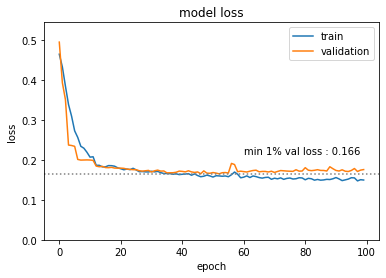

(2766, 20)


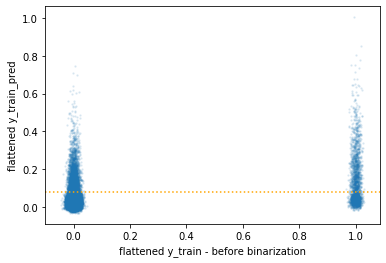

mae =  0.07014147487151842
corr =  0.37753554317149807
r_sqrd =  0.12922


[0.13810557 0.11062907 0.10375994 0.05169921 0.08315257 0.
 0.0625452  0.09544469 0.10375994 0.09436008 0.0813449  0.09219089
 0.05531453 0.03000723 0.08315257 0.12617499 0.13702098 0.05639913
 0.12509039 0.1088214 ]
10
33
56


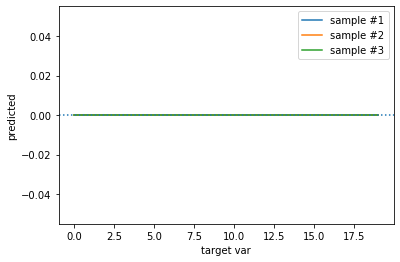

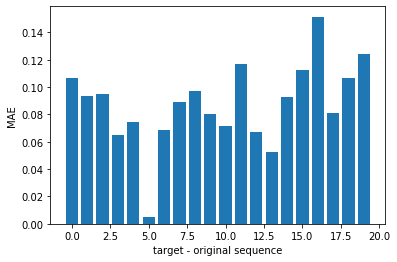

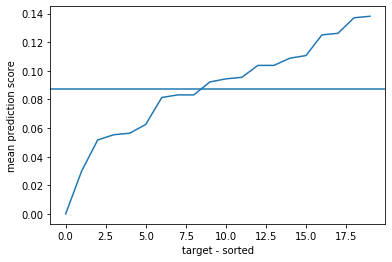

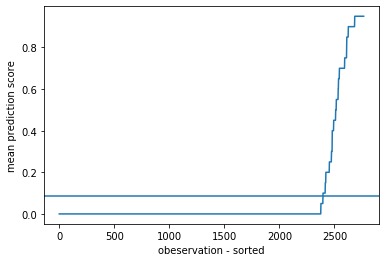

range of prediction :  0.0 1.0


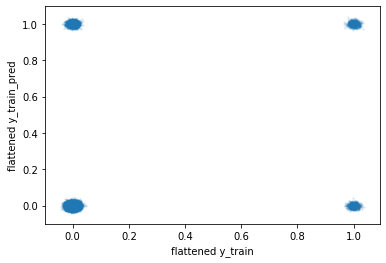


Accuracy: 91.25

Confusion Matrix : 
 [[49304  3637]
 [ 1206  1173]]

Recall % :  49.30643127364439


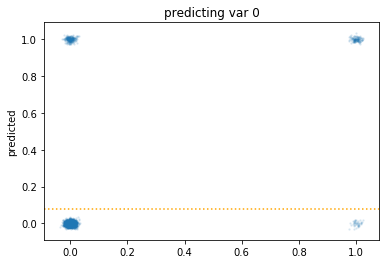

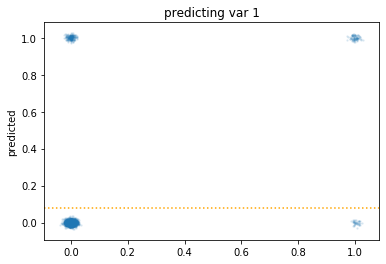

In [69]:
print(history.history.keys())

# "Loss"
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
max_loss = np.max([np.max(history.history['loss']), np.max(history.history['val_loss'])])
plt.ylim(0,max_loss*1.1)
min1pcntloss = np.percentile(history.history['val_loss'],1)
plt.axhline(min1pcntloss, color='grey', linestyle=':')
losstext = 'min 1% val loss : ' + str(round(min1pcntloss,3))
plt.text(60, min1pcntloss+0.05, losstext)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


#--------------

y_train_pred = model.predict(X_train)
print(y_train_pred.shape)

cutoff = 0.08

y_train_f = np.array(y_train).flatten()
y_train_pred_f = np.array(y_train_pred).flatten()
y_train_pred_f = np.where(y_train_pred_f>1, 1, y_train_pred_f)

plt.scatter(rjitt(y_train_f), 
            rjitt(y_train_pred_f), alpha=0.1, s=2)
plt.xlabel('flattened y_train - before binarization')
plt.ylabel('flattened y_train_pred')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.show()

print('mae = ', abs(y_train_f - y_train_pred_f).mean())
print('corr = ' , np.corrcoef(y_train_f, y_train_pred_f)[0,1])

from sklearn.metrics import r2_score
print('r_sqrd = ', round(r2_score(y_train_f, y_train_pred_f),5))
print('\n')


# check difference in each column
for x in range(nitm):
    y_train_pred[:, x] = np.where(y_train_pred[:, x]<cutoff,0, 1)

print(y_train_pred.mean(axis=0))    

# check sample records
for x in range(3):
    x1 = (23*x) + 10 
    print(x1)
    plt.plot(y_train_pred[x1,:])
plt.legend(['sample #1','sample #2','sample #3'])
plt.axhline(0, linestyle=':')
plt.xlabel('target var')
plt.ylabel('predicted')
plt.show()


# check MAE of each target
mae_list = np.array([]).astype(float)
for x in range(nitm):
    mae_list = np.append(mae_list, round(abs(y_train_pred[:, x] - y_train.iloc[:, x]).mean(),4))
plt.bar(list(range(nitm)), mae_list)    
plt.xlabel('target - original sequence')
plt.ylabel('MAE')
plt.show()


plt.plot(np.sort(y_train_pred.mean(axis=0)))
plt.xlabel('target - sorted')
plt.ylabel('mean prediction score')
plt.axhline(y_train_pred.mean(axis=0).mean())
plt.show()

plt.plot(np.sort(y_train_pred.mean(axis=1)))
plt.xlabel('obeservation - sorted')
plt.ylabel('mean prediction score')
plt.axhline(y_train_pred.mean(axis=1).mean())
plt.show()
print('range of prediction : ', y_train_pred.min(), y_train_pred.max())


y_train_f = np.array(y_train).flatten()
y_train_pred_f = np.array(y_train_pred).flatten()
plt.scatter(rjitt(y_train_f), 
            rjitt(y_train_pred_f), alpha=0.1, s=2)
plt.xlabel('flattened y_train')
plt.ylabel('flattened y_train_pred')
plt.show()


y_train_predc = np.where(y_train_pred >cutoff, 1, 0)
y_trainc = np.where(y_train >cutoff, 1, 0)


from sklearn.metrics import accuracy_score
# evaluate model :: check accuracy

accuracy = accuracy_score(y_train_f, y_train_pred_f)
print('\nAccuracy: %.2f' % (accuracy*100))


# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(list(y_train_f), list(y_train_pred_f))
print('\nConfusion Matrix : \n', cnf_matrix)
print('\nRecall % : ', (cnf_matrix[1,1])/(cnf_matrix[1].sum())*100)


plt.scatter(rjitt(y_train.iloc[:,0]), rjitt(y_train_pred[:,0]),
            s=2, alpha=0.1)
plt.title('predicting var 0')
plt.ylabel('predicted')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.show()

plt.scatter(rjitt(y_train.iloc[:,1]), rjitt(y_train_pred[:,1]),
            s=2, alpha=0.1)
plt.title('predicting var 1')
plt.ylabel('predicted')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.show()


### Check testset (m+1) performance
- 8월 중의 카테고리별 고객 이용패턴을 예측 결과와 비교 

In [70]:
# Months for test X
tr023 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-05', '2011-06', '2011-07'])]
# Months for test Y
tr024 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-08'])]

tr11 = tr023[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()
print(tr11.shape)

tr12 = tr11.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr12.fillna(0, inplace=True)

# add prefix sc
sc_list = np.char.array(['sc']) + np.array(tr12.columns[1:(nitm+1)])
tr12.columns = np.concatenate([np.array(['CustomerID']), sc_list])

tr13 = tr024[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()

tr14 = tr13.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr14.fillna(0, inplace=True)

# add prefix sc
sc_list = np.char.array(['sct']) + np.array(tr14.columns[1:(nitm+1)])
tr14.columns = np.concatenate([np.array(['CustomerID']), sc_list])
print(tr14.shape)

tr15 = tr12.merge(tr14, on='CustomerID', how='left')
tr15.fillna(0, inplace=True)
tr15.head()

X_test = tr15.iloc[:,1:(nitm+1)]
y_test = tr15.iloc[:,(nitm+1):((2*nitm)+1)]



(4213, 3)
(598, 21)


In [71]:
# to binarize target :: # 10개 item의 구매여부를 classification 문제 형식으로 정의

# for x in range(nitm):
#     y_test.iloc[:,x] = np.where(y_test.iloc[:,x]>0,1,0)
#     X_test.iloc[:,x] = np.where(X_test.iloc[:,x]>0,1,0)

In [72]:
# to binarize target :: # 10개 item의 구매여부를 classification 문제 형식으로 정의
# to quantile-based normalize inputs (c.f. YouTube 2016)

from scipy.stats import percentileofscore

for x in range(nitm):
    y_test.iloc[:,x] = np.where(y_test.iloc[:,x]>0,1,0) # Target
    
    arr_sorted =  sorted(np.array(X_test.iloc[:,x].copy()))
    s = X_test.iloc[:,x]
    X_test.iloc[:,x] = mnmx_scl(s.apply(lambda x: percentileofscore(arr_sorted, x)/100))  # inputs
    

In [73]:
# add super and sub linear derivatives of input features

X_test_supl = X_test.apply(lambda x: x*x)
X_test_supl.columns = np.char.array(['sup']) + np.array(X_test_supl.columns)

X_test_subl = X_test.apply(lambda x: np.sqrt(x))
X_test_subl.columns = np.char.array(['sub']) + np.array(X_test_subl.columns)

X_test = pd.concat([X_test, X_test_supl, X_test_subl], axis=1)
X_test.shape

(1384, 60)

(1384, 20)
(1384, 20) (27680,) (27680,)


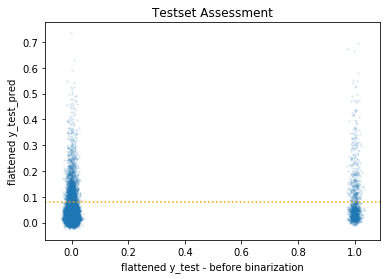

mae =  0.07539560651777426
corr =  0.21372553669011687
r_sqrd =  0.04356


[0.14089595 0.10765896 0.09537572 0.03540462 0.07514451 0.
 0.04624277 0.08815029 0.09682081 0.08381503 0.06864162 0.08309249
 0.04046243 0.02095376 0.07297688 0.12644508 0.14378613 0.04190752
 0.12644508 0.10115607]
10
30
50


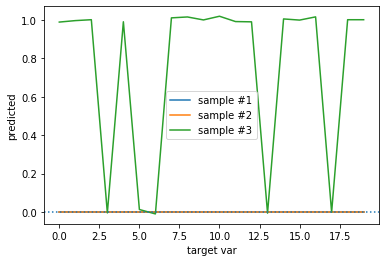

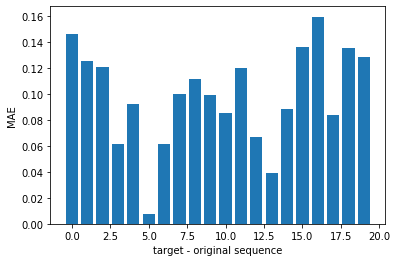

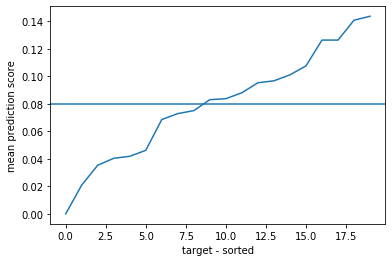

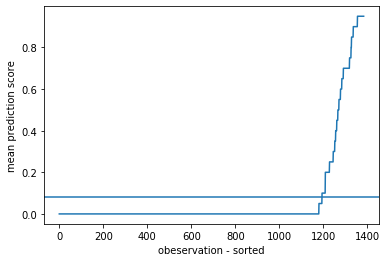

range of prediction :  0.0 1.0


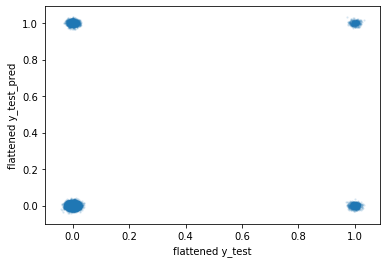


Accuracy: 90.14

Confusion Matrix : 
 [[24572  1828]
 [  900   380]]

Recall % :  29.6875


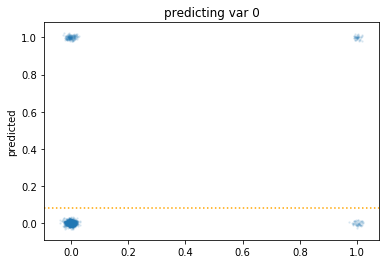

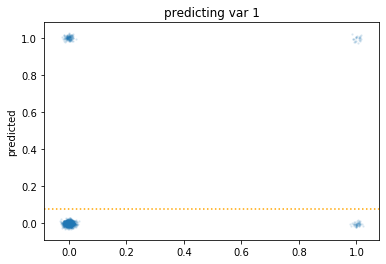

In [74]:
y_test_pred = model.predict(X_test)
print(y_test_pred.shape)

cutoff = 0.08

y_test_f = np.array(y_test).flatten()
y_test_pred_f = np.array(y_test_pred).flatten()
y_test_pred_f = np.where(y_test_pred_f>1, 1, y_test_pred_f)

print(y_test.shape, y_test_f.shape, y_test_pred_f.shape)

plt.scatter(rjitt(y_test_f), 
            rjitt(y_test_pred_f), alpha=0.1, s=2)
plt.xlabel('flattened y_test - before binarization')
plt.ylabel('flattened y_test_pred')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.title('Testset Assessment')
plt.show()

print('mae = ', abs(y_test_f - y_test_pred_f).mean())
print('corr = ' , np.corrcoef(y_test_f, y_test_pred_f)[0,1])

from sklearn.metrics import r2_score
print('r_sqrd = ', round(r2_score(y_test_f, y_test_pred_f),5))
print('\n')


# check difference in each column
for x in range(nitm):
    y_test_pred[:, x] = np.where(y_test_pred[:, x]<cutoff,0, 1)

print(y_test_pred.mean(axis=0))    

# check sample records
for x in range(3):
    x1 = (20*x) + 10 
    print(x1)
    plt.plot(rjitt(y_test_pred[x1,:]))
plt.legend(['sample #1','sample #2','sample #3'])
plt.axhline(0, linestyle=':')
plt.xlabel('target var')
plt.ylabel('predicted')
plt.show()


# check MAE of each target
mae_list = np.array([]).astype(float)
for x in range(nitm):
    mae_list = np.append(mae_list, round(abs(y_test_pred[:, x] - y_test.iloc[:, x]).mean(),4))
plt.bar(list(range(nitm)), mae_list)    
plt.xlabel('target - original sequence')
plt.ylabel('MAE')
plt.show()


plt.plot(np.sort(y_test_pred.mean(axis=0)))
plt.xlabel('target - sorted')
plt.ylabel('mean prediction score')
plt.axhline(y_test_pred.mean(axis=0).mean())
plt.show()

plt.plot(np.sort(y_test_pred.mean(axis=1)))
plt.xlabel('obeservation - sorted')
plt.ylabel('mean prediction score')
plt.axhline(y_test_pred.mean(axis=1).mean())
plt.show()
print('range of prediction : ', y_test_pred.min(), y_test_pred.max())


y_test_f = np.array(y_test).flatten()
y_test_pred_f = np.array(y_test_pred).flatten()
plt.scatter(rjitt(y_test_f), 
            rjitt(y_test_pred_f), alpha=0.1, s=2)
plt.xlabel('flattened y_test')
plt.ylabel('flattened y_test_pred')
plt.show()


y_test_predc = np.where(y_test_pred >cutoff, 1, 0)
y_testc = np.where(y_test >cutoff, 1, 0)


from sklearn.metrics import accuracy_score
# evaluate model :: check accuracy

accuracy = accuracy_score(y_test_f, y_test_pred_f)
print('\nAccuracy: %.2f' % (accuracy*100))


# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(list(y_test_f), list(y_test_pred_f))
print('\nConfusion Matrix : \n', cnf_matrix)
print('\nRecall % : ', (cnf_matrix[1,1])/(cnf_matrix[1].sum())*100)


plt.scatter(rjitt(y_test.iloc[:,0]), rjitt(y_test_pred[:,0]),
            s=2, alpha=0.1)
plt.title('predicting var 0')
plt.ylabel('predicted')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.show()

plt.scatter(rjitt(y_test.iloc[:,1]), rjitt(y_test_pred[:,1]),
            s=2, alpha=0.1)
plt.title('predicting var 1')
plt.ylabel('predicted')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.show()

- (batchsize 16, epoch 200) is more accurate than (batchsize 32, epoch 150)
- quantile normalization adds value. Still there seems to be a room to calibrate further
- adding super and sub linear derivative input features seems to work a litte

[Discussion]
- Why not 100% accurate?
- Seasonal difference in item popularity?
- Inpust and targets should be from the same item pool?

## 5.5. Making Recommendations (=Inference)

In [75]:
# randomly select 100 customers from testset 

nsmpls = 300
trtestrun = tr15.sample(n=nsmpls, replace=False)

testrun_smp_idx = trtestrun.index
print(X_test.iloc[testrun_smp_idx].shape)
X_test.iloc[testrun_smp_idx].head()


(300, 60)


,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,sc22386,...,subsc22411,subsc22423,subsc22457,subsc22469,subsc22720,subsc23203,subsc47566,subsc84879,subsc85099B,subsc85123A
461,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.926998,0.0,0.882828,0.0,0.000000,0.0,0.00000
314,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.86636
860,0.0,0.0,0.0,0.0,0.0,0.0,0.878272,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000
122,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.882843,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.86636
1203,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.903884,0.0,0.00000


In [76]:
w, h = nitm, nsmpls

testrecomm_mat = np.array([[None for x in range(w)] for y in range(h)])

testrunX = X_test.iloc[testrun_smp_idx]
testrunY = y_test.iloc[testrun_smp_idx]

for j in range(len(testrun_smp_idx)):
    # print(j, testrun_smp_idx[j])
    X_testrun = testrunX.loc[testrun_smp_idx[j],:]
    # print(X_testrun, X_testrun.shape)
    
    y_test_pred = model.predict(np.array(X_testrun).reshape((-1,60)))
    # print(y_test_pred)
        
    # [ alternatively ] above median probability can be used as the threshold
    # y_test_pred[0] = np.where(y_test_pred[0]>=np.median(y_test_pred[0]), 1, 0)
    # y_test_pred[0] = np.where(y_test_pred[0]>=0.02, 1, 0)
    
    # not to recommend items already purchased during X period
    recomm = y_test_pred[0] - testrunY.loc[testrun_smp_idx[j],:]
    recomm = np.where(recomm <0, 0, recomm)
    
    # 20개 아이템 중 스코어 순 상위 3개만 선정해서 순서대로 추천
    recomm = np.array(recomm).flatten()   
    recomm = [round(d,4) if d >= np.percentile(recomm,85) and d>0 else 0 for d in recomm]
    if j > (len(testrun_smp_idx)-15):
        print('recomm for test cust ', j ,' : ' , recomm )
    testrecomm_mat[j,:] = recomm
    

recomm for test cust  286  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.043, 0, 0, 0, 0, 0.0513, 0.0541, 0, 0]
recomm for test cust  287  :  [0.2072, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.15, 0, 0.177, 0]
recomm for test cust  288  :  [0.1381, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1081, 0, 0.1082, 0]
recomm for test cust  289  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.043, 0, 0, 0, 0, 0.0513, 0.0541, 0, 0]
recomm for test cust  290  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.043, 0, 0, 0, 0, 0.0513, 0.0541, 0, 0]
recomm for test cust  291  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.043, 0, 0, 0, 0, 0.0513, 0.0541, 0, 0]
recomm for test cust  292  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.043, 0.0422, 0, 0, 0, 0.0513, 0, 0, 0]
recomm for test cust  293  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.043, 0, 0, 0, 0, 0.0513, 0.0541, 0, 0]
recomm for test cust  294  :  [0.0497, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0457, 0, 0, 0, 0, 0.0571, 0, 0, 0]
recomm for test cust  295  :  [0, 0, 0, 0, 0, 0, 0, 0, 

In [77]:
y_train.mean()

sct20725     0.062184
sct20727     0.048807
sct20728     0.047361
sct21212     0.027477
sct21931     0.030730
sct22086     0.004700
sct22197     0.030369
sct22382     0.040492
sct22383     0.047361
sct22386     0.039407
sct22411     0.027838
sct22423     0.050615
sct22457     0.024946
sct22469     0.031092
sct22720     0.039046
sct23203     0.066522
sct47566     0.080260
sct84879     0.037961
sct85099B    0.062907
sct85123A    0.060014
dtype: float64

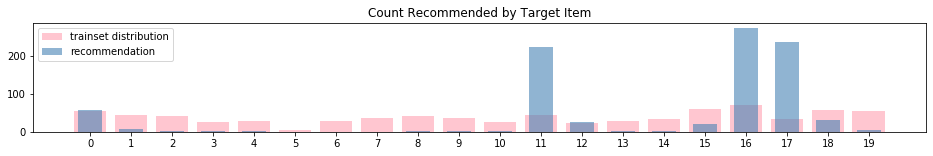

Total Count Recommended :  900.0 ( 100.0 %)


In [78]:
means = np.array([])
for x in range(nitm):
    tmp_cnt = np.array([1 if y >0 else y for y in testrecomm_mat[:,x]])
    means = np.append(means, tmp_cnt.sum())

plt.figure(figsize=(16,2))
var_labels = np.array(range(nitm)).astype(str)
plt.bar(var_labels, y_train.mean()*nsmpls*3, color='pink', alpha=0.9)
plt.bar(var_labels, means, color='steelblue', width=0.6, alpha=0.6)
plt.title('Count Recommended by Target Item')
plt.legend(['trainset distribution','recommendation'])
plt.show()


# 3건 모두 추천이 이루어진 건의 수와 비율 확인
print('Total Count Recommended : ', means.sum(), '(', round(means.sum()/(h*3)*100,2), '%)')

- 기준을 만족하는 제안건이 3건이 되지 않는 경우도 발생 가능
- 무조건 3건을 채우기로 한 경우라면 이를 위한 추가적인 장치 (e.g. random, simple logic) 마련 필요 
- 보다 popular한 item 혹은 특정 item으로 추천이 집중되는 쏠림 현상 보임 (참고: 일부는 이미 구매한 상품을 제외한 영향)
- Score 자체를 그대로 사용하는 대신 추천 분산을 유도하는 로직 적용 필요

- recsys 2019 paper on YouTube explained :  https://towardsdatascience.com/how-youtube-recommends-videos-b6e003a5ab2f 